In [1]:
SERVO_FREQ = 60000
DT = 1 / SERVO_FREQ
NUM_T_SAMPLES4PLOT = 1000
CHIRP_MARGIN = 0.8
SUCCESS = 1
FAILED = 0
YES = 1
NO = 0

import numpy as np
from sympy.core import symbols
from sympy import simplify, cancel, Poly, fraction
from scipy.linalg import hankel
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt


class TransferFunc(object):
    def __init__(self, num, den, dt):
        self.num = num
        self.den = den
        self.dt = dt
        z = symbols("z")
        _nom_d = _den_d = 0
        for _i in range(len(num)):
            _nom_d += num[-_i - 1] * (2 / dt * (z - 1) / (z + 1)) ** _i
        for _i in range(len(den)):
            _den_d += den[-_i - 1] * (2 / dt * (z - 1) / (z + 1)) ** _i
        nom_d, den_d = cancel(simplify(_nom_d / _den_d)).as_numer_denom()
        self.nom_d = nom_d.as_poly(z).all_coeffs()
        self.den_d = den_d.as_poly(z).all_coeffs()
        self.input_array = np.zeros_like(self.nom_d)
        self.output_array = np.zeros_like(self.den_d)
        self.output = 0

    def __get_operation_coeffs(self, other):
        s = symbols("s")
        self_nom = Poly(self.num, s).as_expr(s)
        self_den = Poly(self.den, s).as_expr(s)
        other_nom = Poly(other.num, s).as_expr(s)
        other_den = Poly(other.den, s).as_expr(s)
        return s, self_nom, self_den, other_nom, other_den

    def __add__(self, other):
        s, self_nom, self_den, other_nom, other_den = self.__get_operation_coeffs(other)
        res_sys_s = cancel(simplify(self_nom / self_den + other_nom / other_den))
        _res_nom, _res_den = res_sys_s.as_numer_denom()
        res_nom = _res_nom.as_poly(s).all_coeffs()
        res_den = _res_den.as_poly(s).all_coeffs()
        res_sys = TransferFunc(res_nom, res_den, self.dt)
        return res_sys

    def __sub__(self, other):
        s, self_nom, self_den, other_nom, other_den = self.__get_operation_coeffs(other)
        res_sys_s = cancel(simplify(self_nom / self_den - other_nom / other_den))
        _res_nom, _res_den = res_sys_s.as_numer_denom()
        res_nom = _res_nom.as_poly(s).all_coeffs()
        res_den = _res_den.as_poly(s).all_coeffs()
        res_sys = TransferFunc(res_nom, res_den, self.dt)
        return res_sys

    def __mul__(self, other):
        s, self_nom, self_den, other_nom, other_den = self.__get_operation_coeffs(other)
        res_sys_s = cancel(simplify(self_nom / self_den * other_nom / other_den))
        _res_nom, _res_den = res_sys_s.as_numer_denom()
        res_nom = _res_nom.as_poly(s).all_coeffs()
        res_den = _res_den.as_poly(s).all_coeffs()
        res_sys = TransferFunc(res_nom, res_den, self.dt)
        return res_sys

    def __truediv__(self, other):
        s, self_nom, self_den, other_nom, other_den = self.__get_operation_coeffs(other)
        res_sys_s = cancel(simplify(self_nom / self_den / (other_nom / other_den)))
        _res_nom, _res_den = res_sys_s.as_numer_denom()
        res_nom = _res_nom.as_poly(s).all_coeffs()
        res_den = _res_den.as_poly(s).all_coeffs()
        res_sys = TransferFunc(res_nom, res_den, self.dt)
        return res_sys

    def response(self, input_sig):
        self.input_array = np.delete(np.insert(self.input_array, 0, input_sig), -1)
        self.output_array = np.delete(np.insert(self.output_array, 0, 0), -1)
        self.output = (
            np.dot(self.input_array, self.nom_d)
            - np.dot(self.output_array[1::], self.den_d[1::])
        ) / self.den_d[0]
        self.output_array[0] = self.output
        return self.output

    def bode_plot(self, low, up):
        f = 10 ** np.arange(low, up, 0.01)
        omega = 2 * np.pi * f
        num = den = 0
        for i in range(len(self.num)):
            num = num + self.num[-i - 1] * (1j * omega) ** i
        for i in range(len(self.den)):
            den = den + self.den[-i - 1] * (1j * omega) ** i
        num = num.astype("complex")
        den = den.astype("complex")

        gain = 20 * np.log10(np.abs(num / den))
        phase = np.angle(num / den)

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        axes[0].set_xlabel("f/[Hz]")
        axes[0].set_ylabel("Gain/[dB]")
        axes[0].semilogx(f, gain)

        axes[1].set_xlabel("f/[Hz]")
        axes[1].set_ylabel("Phase/[rad]")
        axes[1].semilogx(f, phase)

        plt.suptitle("Bode plot")
        plt.show()


def dft_slow(src_data):
    num = len(src_data) - 1
    fw = np.zeros(num, dtype=complex)
    for k in range(num):
        for _n in range(num):
            fw[k] += src_data[_n] * np.e ** (1j * 2 * np.pi / num * _n * k)
    gain = [abs(_) for _ in fw]
    return gain


def dft_vectorized(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    num = x.shape[0]
    n = np.arange(num)
    k = n.reshape((num, 1))
    m = np.exp(-2j * np.pi * k * n / num)
    return np.dot(m, x)


def fft_slow(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    num = x.shape[0]

    if num % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif num <= 32:  # this cutoff should be optimized
        return dft_vectorized(x)
    else:
        x_even = fft_slow(x[::2])
        x_odd = fft_slow(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(num) / num)
        return np.concatenate(
            [
                x_even + factor[: int(num / 2)] * x_odd,
                x_even + factor[int(num / 2) :] * x_odd,
            ]
        )


def _fft(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    num = x.shape[0]

    if np.log2(num) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # _N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    num_min = min(num, 32)

    # Perform an O[N^2] DFT on all length-_N_min sub-problems at once
    n = np.arange(num_min)
    k = n[:, None]
    m = np.exp(-2j * np.pi * n * k / num_min)
    mat_x = np.dot(m, x.reshape((num_min, -1)))

    # build-up each level of the recursive calculation all at once
    while mat_x.shape[0] < num:
        x_even = mat_x[:, : int(mat_x.shape[1] / 2)]
        x_odd = mat_x[:, int(mat_x.shape[1] / 2) :]
        factor = np.exp(-1j * np.pi * np.arange(mat_x.shape[0]) / mat_x.shape[0])[
            :, None
        ]
        mat_x = np.vstack([x_even + factor * x_odd, x_even - factor * x_odd])

    return mat_x.ravel()


def hamm(x):
    x = np.array(x)
    num = len(x)
    hamm_window = 0.53836 - 0.46164 * np.cos(2 * np.pi * np.arange(num) / num)
    x = x * hamm_window

    return x


def anti_hamm(x):
    x = np.array(x)
    num = len(x)
    hamm_window = 0.5 * (1 + np.cos(2 * np.pi * np.arange(num) / (num - 1)))
    x = x * hamm_window

    return x


def half_hamm(x):
    x = np.array(x)
    num = len(x)
    hamm_window = 0.53836 + 0.46164 * np.cos(np.pi * np.arange(num) / (num - 1))

    x = x * hamm_window
    return x


def pad(x):
    num = len(x)
    num_pad = int(2 ** np.ceil(np.log2(num)))
    x_pad = np.pad(x, (0, num_pad - num))
    return x_pad


def fft(x, dt):
    x_pad = pad(x)
    num_pad = len(x_pad)
    fs = 1 / (num_pad * dt)
    f_pad = fs * np.arange(num_pad)

    fw_pad = _fft(x_pad)

    return f_pad, fw_pad


In [2]:
dt = 1/60000
T = 0.1
N = T/dt
t = np.arange(0, T, dt)

f_chirp_start = 8
f_chirp_end = 2000


_f_chirp_start = f_chirp_start
_f_chirp_end = f_chirp_end

u = np.sin(2 * np.pi * ((_f_chirp_end - _f_chirp_start) / T *
                            t ** 2 / 2 + _f_chirp_start * t))

res_freq = 200
anti_res_freq = 150
res_omega = res_freq * 2 * np.pi
anti_res_omega = anti_res_freq * 2 * np.pi

beta1 = 0.1
beta2 = 0.1

sys = TransferFunc(res_omega**2/anti_res_omega**2*np.array([1,2*beta1*anti_res_omega,anti_res_omega**2]),\
                        np.array([1,2*beta2*res_omega,res_omega**2]), dt)

# sys = TransferFunc([1,0.0001],[1,0], dt)


p = np.array([0])
v = np.array([0])
a = np.array([])

for i in range(len(u)):
    input_sig = u[i]
    a_current = sys.response(input_sig)#+random.normal()/4/5
    a = np.append(a, a_current)
    v_current = v[-1] + a_current * dt
    v = np.append(v, v_current)
    p_current = p[-1] + v_current * dt#+random.normal()/4/100
    p = np.append(p, p_current)

p = np.delete(p, 0)
v = np.delete(v, 0)
y = np.array(p, dtype=float)

y = np.pad(np.diff(y,2),(2,0),constant_values = 0)


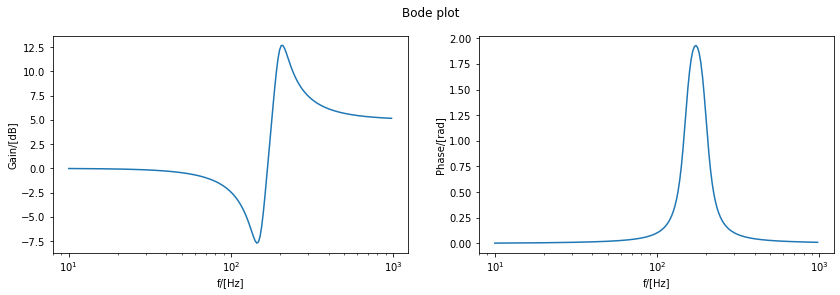

In [4]:
sys.bode_plot(1,3)

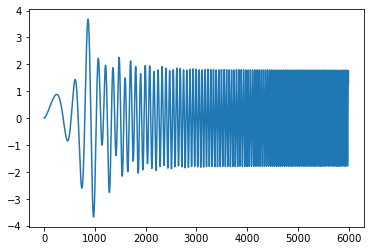

In [17]:
plt.plot(a)

In [18]:
for i in range(len(u)):
    input_sig = u[i]
    a_current = sys.response(input_sig)#+random.normal()/4/5
    a = np.append(a, a_current)
    v_current = v[-1] + a_current * (1/dt)
    v = np.append(v, v_current)
    p_current = p[-1] + v_current * (1/dt)#+random.normal()/4/100
    p = np.append(p, p_current)

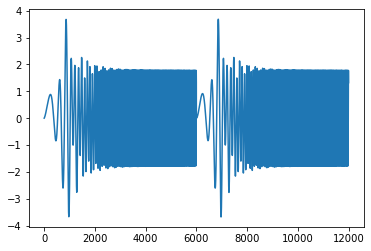

In [19]:
plt.plot(a)